In [1]:
import numpy as np,pandas as pd
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,auc,f1_score
from sklearn.metrics import confusion_matrix,accuracy_score
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.preprocessing import LabelEncoder

In [2]:
test=pd.read_csv('./test_2umaH9m.csv')
train=pd.read_csv('./train_LZdllcl.csv')
sub=pd.read_csv('./sample_submission_M0L0uXE.csv')
test.shape,train.shape,sub.shape

((23490, 13), (54808, 14), (23490, 2))

In [3]:
EID,TARGET='employee_id','is_promoted'

In [4]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [5]:
train.education.fillna("_na_",inplace=True)
test.education.fillna("_na_",inplace=True)
train.previous_year_rating.fillna(0,inplace=True)
test.previous_year_rating.fillna(0,inplace=True)

In [6]:
def multi_encode(train,test,column,name):
    temp=train.groupby(column)['is_promoted'].agg(['mean']).reset_index().rename(columns={'mean':name+'_mean'})
    train=pd.merge(train,temp,on=column,how='left')
    test=pd.merge(test,temp,on=column,how='left')
    return train,test

In [7]:
columns=[['department','gender'],['department','gender','education'],['department','region']]
name=['dg','dge','dr']
for i in range(len(columns)):
    train,test=multi_encode(train,test,columns[i],name[i])


In [8]:
train['has_more_training']=train.avg_training_score.apply(lambda x : 1 if x >= 71 else 0)
test['has_more_training']=test.avg_training_score.apply(lambda x : 1 if x >= 71 else 0)

In [9]:
train['has_more_rating']=train.previous_year_rating.apply(lambda x : 1 if x >= 4 else 0)
test['has_more_rating']=test.previous_year_rating.apply(lambda x : 1 if x >= 4 else 0)

In [10]:
def encode(train,test,column):
    temp=train.groupby([column])['is_promoted'].agg(['mean']).reset_index().rename(columns={'mean':column+'_mean'})
    train=pd.merge(train,temp,on=column,how='left')
    test=pd.merge(test,temp,on=column,how='left')
    train.drop(column,axis=1,inplace=True)
    test.drop(column,axis=1,inplace=True)
    return train,test

In [11]:
train.is_promoted.value_counts()/train.shape[0]

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

In [12]:
for i in train.columns:
    if train[i].dtype=='object':
        train,test=encode(train,test,i)
    

In [13]:
train.head()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,dg_mean,dge_mean,dr_mean,has_more_training,has_more_rating,department_mean,region_mean,education_mean,gender_mean,recruitment_channel_mean
0,65438,1,35,5.0,8,1,0,49,0,0.055802,0.061272,0.107564,0,1,0.072031,0.106546,0.098559,0.089934,0.085013
1,65141,1,30,5.0,4,0,0,60,0,0.087093,0.080565,0.132600,0,1,0.090148,0.114188,0.082031,0.083151,0.083952
2,7513,1,34,3.0,7,0,0,50,0,0.075771,0.075272,0.026022,0,0,0.072031,0.060641,0.082031,0.083151,0.085013
3,2542,2,39,1.0,10,0,0,50,0,0.075771,0.075272,0.096000,0,0,0.072031,0.116596,0.082031,0.083151,0.083952
4,48945,1,45,3.0,2,0,0,73,0,0.112874,0.108262,0.114286,1,0,0.107593,0.063274,0.082031,0.083151,0.083952


In [14]:
X=train.drop([EID,TARGET],axis=1)
Y=train[TARGET]
X.shape,Y.shape

((54808, 17), (54808,))

In [34]:
rs=4
x_train,x_test,y_train,y_test= train_test_split(X,Y,test_size=0.10,random_state=rs)

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

In [42]:

param = {
    'max_depth':6, # the maximum depth of each tree
    'eta': 0.1,     # the training step for each iteration
    'silent': 1,    # logging mode - quiet
    'objective': 'binary:logistic',  # error evaluation for multiclass training
    'eval_metric':'auc'
}                       

num_round =300
bst0 = xgb.train(param, dtrain, num_round)
pred_xg = bst0.predict(dtest)
print(roc_auc_score(y_test,pred_xg))
pred_x=np.where(pred_xg>=0.5,1,0)
print(f1_score(y_test,pred_x))

0.9128990939059065
0.535031847133758


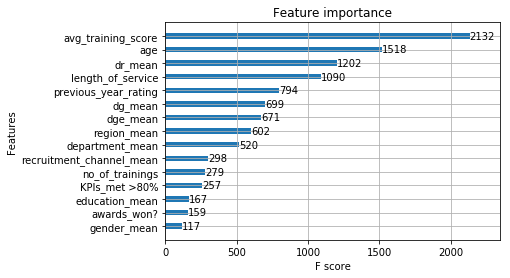

In [43]:
plot_importance(bst0,height=0.4,)

In [44]:
import lightgbm as lgb

In [45]:
x_train,x_test,y_train,y_test= train_test_split(X,Y,test_size=0.10,random_state=0)

train_data=lgb.Dataset(x_train,label=y_train)

In [62]:
param = {'num_leaves':50, 'objective':'binary','max_depth':8,'learning_rate':.1,'max_bin':50}
param['metric'] = ['auc']
num_round=400
lgbm=lgb.train(param,train_data,num_round)
pred_lg=lgbm.predict(x_test)               
print(roc_auc_score(y_test,pred_lg))
pred_x=np.where(pred_lg>=0.5,1,0)
print(f1_score(y_test,pred_x))

0.9016601951807186
0.5323076923076923


In [64]:
pred_lg=lgbm.predict(test[x_train.columns])

In [65]:
ddtest=xgb.DMatrix(test[x_train.columns])
pred_xg=bst0.predict(ddtest)

In [69]:
pred=0.5*pred_lg+0.5*pred_xg
pred=np.where(pred>=0.3,1,0)
sub[TARGET]=pred
sub.head()

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0


In [70]:
sub.shape

(23490, 2)

In [71]:
sub.is_promoted.value_counts()/sub.shape[0]

0    0.942358
1    0.057642
Name: is_promoted, dtype: float64

In [72]:
sub.to_csv('sub-lgb-xgb-1.csv',index=False)